In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle5 as pickle
import seaborn as sns
import time
import datetime
from nn import DataSynthesizer
from transformer import DataTransformer

import importlib
import reverse_xfm
importlib.reload(reverse_xfm)
from reverse_xfm import reverse_samples_for_analysis, xfm_data_for_modelling
from sklearn.mixture import GaussianMixture as GMM
from data_analyser import DataAnalyser
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%time
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

CPU times: user 1.53 s, sys: 292 ms, total: 1.82 s
Wall time: 1.82 s


In [40]:
df['send_rec_pair'] = df['52a_sender'] + df['57a_receiver']

##### Use this variable to run a smaller sample

In [4]:
run_sample = True

In [5]:
%%time
if run_sample:
    df, data = xfm_data_for_modelling(df[:1000])
else:
    df, data = xfm_data_for_modelling(df)

Saving source data prepared for modeling..
CPU times: user 55.8 ms, sys: 399 µs, total: 56.2 ms
Wall time: 55 ms


In [6]:
def get_input_data(neg_cond = None):
    if neg_cond is None:
        input_data = data[data['src_xfrr_type'] == 'A']
        sfx = '_a'
    else:
        input_data = data[data['src_xfrr_type'] != 'A']
        sfx = '_fk'
    return input_data, sfx

In [7]:
%%time
input_data, sfx = get_input_data(neg_cond = 'A')
xfm_datafile = f"data/xfm_datafile{sfx}.csv"
xfm_model = f"models/gan_transformer{sfx}.pkl"
gan_model = f"models/gan_model{sfx}.pkl"
reload_data = True
retrain = True

CPU times: user 2.62 ms, sys: 0 ns, total: 2.62 ms
Wall time: 1.95 ms


In [8]:
%%time
print(datetime.datetime.now())
discrete = [col for col in input_data.columns if col not in input_data._get_numeric_data().columns]

2021-09-24 09:45:01.336974
CPU times: user 1.56 ms, sys: 158 µs, total: 1.72 ms
Wall time: 1.13 ms


In [11]:
%%time
print(datetime.datetime.now())

if reload_data:
    transformer = DataTransformer()
    transformer.fit(input_data, discrete)
    data_xfk = transformer.transform(input_data)
    pd.DataFrame(data_xfk).to_csv(xfm_datafile, index=False)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    print(f"Loading Datafile: {xfm_datafile} and Transformer: {xfm_model} !!")
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

2021-09-24 09:45:09.675218
CPU times: user 921 ms, sys: 7.55 ms, total: 929 ms
Wall time: 928 ms


In [12]:
print(datetime.datetime.now())
if retrain:
    synthesizer = DataSynthesizer(epochs = 10, verbose = True, pac = 10, 
                              option = 'cnn', num_filters = [10, 10, 10, 10, 10], 
                              filter_sizes = [2, 3, 4, 5, 6],
                              xfm_indicator = True, transformer = transformer, 
                              xfm_datafile = xfm_datafile)
    synthesizer.fit(data, discrete)
    print("Training completed. Saving the model file !")
    pickle.dump(synthesizer, open(gan_model, 'wb'))
else:
    synthesizer = pickle.load(open(gan_model, 'rb'))

2021-09-24 09:45:16.420286
Initializing synthesizer !!
[[SpanInfo(dim=2, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=4, activation_fn='softmax')], [SpanInfo(dim=2, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=4, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=6, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=4, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=6, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')]]
Tranformer indicator is True
Loading data from data/xfm_datafile_fk.csv
Instantiating discriminator with cnn layer as first set of layers !
[2, 3, 4, 5, 6]
DiscriminatorC(
  (conv1d_list): ModuleList(
    (0): Conv1d(13, 10, k

In [13]:
num_samples = 26000

In [14]:
%%time
print(datetime.datetime.now())
samples_fk = synthesizer.sample(num_samples)

2021-09-24 09:45:23.113662
CPU times: user 6.88 s, sys: 23.5 ms, total: 6.91 s
Wall time: 2.28 s


In [15]:
%%time
samples_fk = reverse_samples_for_analysis(samples_fk, sfx = sfx)

Time elasped for 50f_payor_add_ln_2 = 0.0008743480002522119
Time elasped for src_xfrr_type = 8.79676674700022
Time elasped for 50f_payor_add_lat = 0.00628857700030494
Time elasped for 50f_payor_add_lon = 0.0034009599994533346
Time elasped for 50k_payor_add_lat = 0.002337509999961185
Time elasped for 50k_payor_add_lon = 0.0022687870005029254
Time elasped for 50k_payor_add_ln_2 = 0.0005369179998524487
Time elasped for 50k_payor_add_ln_2 = 7.574238967999918
Time elasped for 59f_ben_add_ln_2 = 13.858269068000482
Time elasped for 59f_ben_add_lat = 0.0011058319996664068
Time elasped for 59f_ben_add_lon = 0.0006584599996131146
Time elasped for 71A_chg_dtls = 0.0006530909995490219
Time elasped for 71f_chg_dtls_cur = 0.0013432219993774197
Time elasped for 71f_chg_dtls_amt = 0.011491813999782607
CPU times: user 776 ms, sys: 261 ms, total: 1.04 s
Wall time: 30.8 s


### Data Analysis and Visualisation
Transaction Source Types - 'F' and 'K'

In [36]:
import scipy
def pdist(x):
    """ Converts a set of values to prob distribution. """
    v = pd.DataFrame(x).value_counts()
    z = np.array([v.to_dict()[x]/v.sum() for x in v.to_dict().keys()])
    return z

def multivariate_kl(data, samples, model):
    """ This function evaluates relatie entropy for probabilty distributions given by 
        gaussian mixture model on actual data and sample data.
    
        Gaussian mixture model fitted on actual data is used to predcit labels for actual 
        and sampled data and the labels are then converted to probabilty distributions to 
        check how close they are.

    """
    data_labels = model.predict(data_xfk)
    samples_labels = model.predict(samples_xfk)
    
    klscore = scipy.special.kl_div(pdist(data_labels), pdist(samples_labels)).sum()
    print()
    print(f"Multivariate KL Divergence score for two datasets : \x1b[1;31m {klscore} \x1b[0m")
    print()
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    ax = axes[0]
    sns.distplot(data_labels, ax = axes[0])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.set_title('Original Data')
    ax = axes[1]
    sns.distplot(samples_labels, ax = axes[1])
    ax.set_title('Synthetic Data')
    plt.show()

def attr_plot(data, samples, discrete = None, numeric = None):
    sns.set(style='whitegrid')
    if discrete is None:
        for col in numeric:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
    else:
        for col in discrete:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data[discrete])
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples[discrete])
            plt.xticks(rotation=45)

def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)
    
    plt.subplot(122)
    sns.heatmap(samples.corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)

discrete = ['33b_cur', 'src_xfrr_type', 'charge_dtls', 'charge_dtls_cur', 'send_rec_pair']
numeric = ['usd_amt', 'src_lon', 'src_lat', 'target_lat', 'target_lon', 'charge_dtls_amt']

##### KL Divergence

###### Multivariate

In [23]:
synthesizer_fk = GMM(n_components = 10, covariance_type = "full", random_state = 0).fit(data_xfk)

In [26]:
samples_xfk = transformer.transform(samples_fk)


Multivariate KL Divergence score for two datasets :  0.020881650373675502 



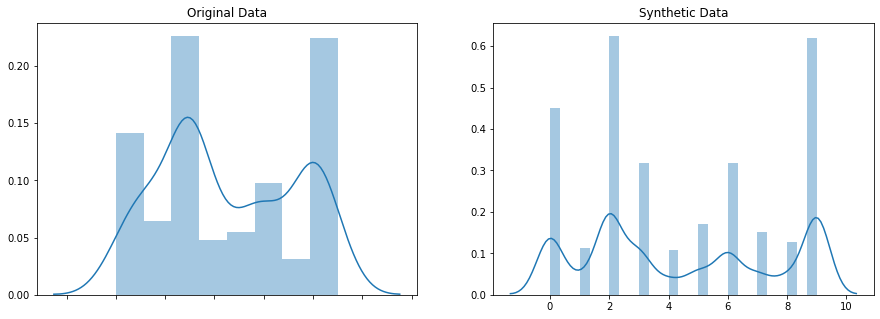

In [37]:
multivariate_kl(data_xfk, samples_xfk, synthesizer_fk)

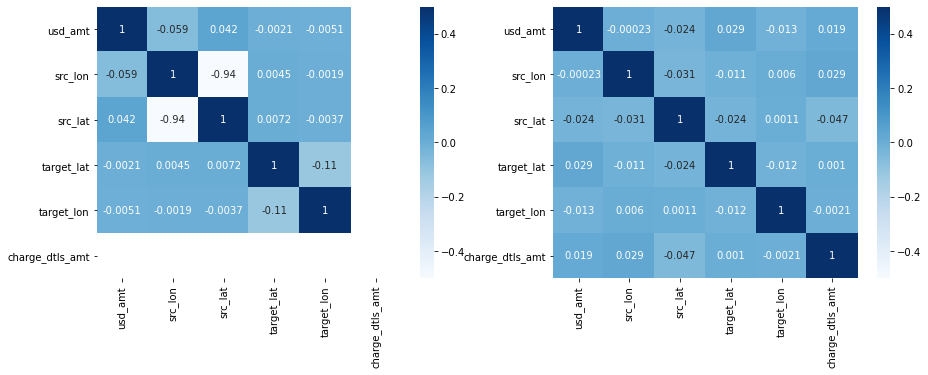

In [38]:
corrplot(df[numeric], samples_fk[numeric])

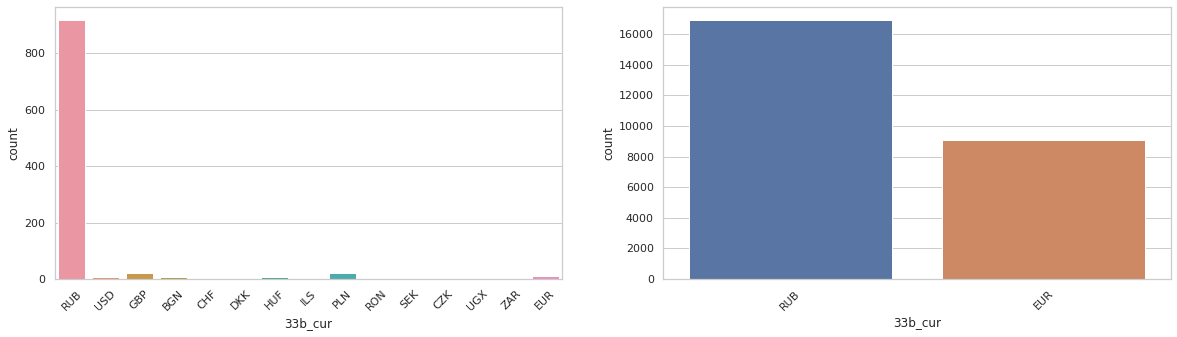

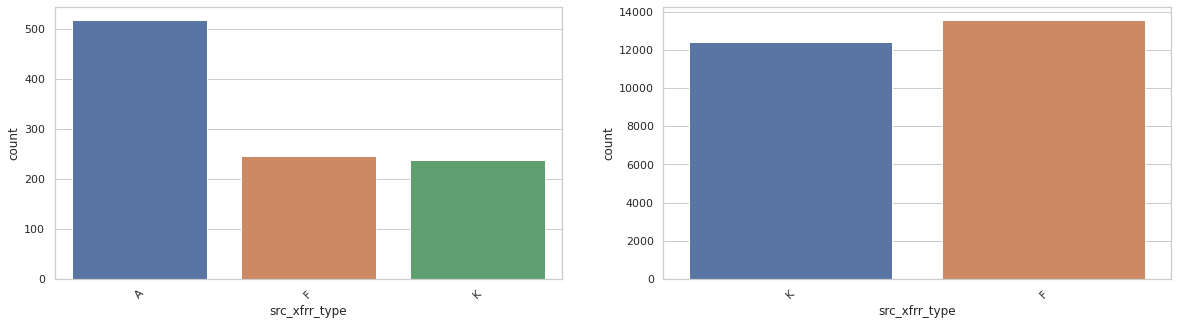

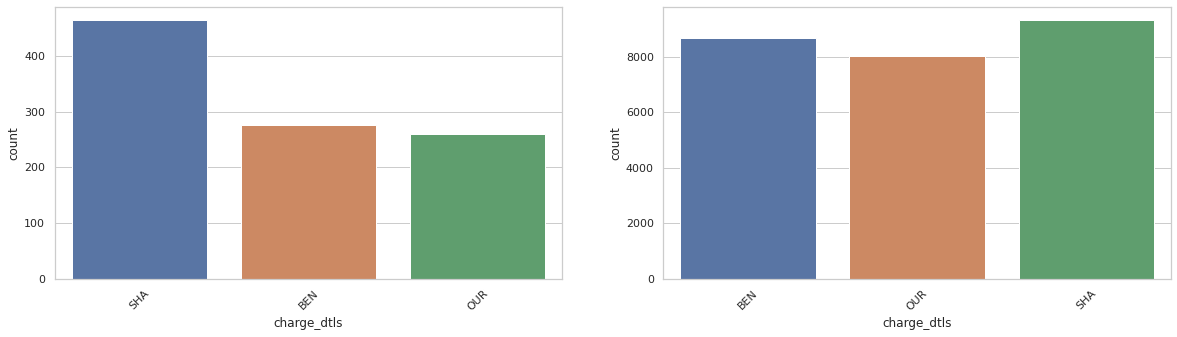

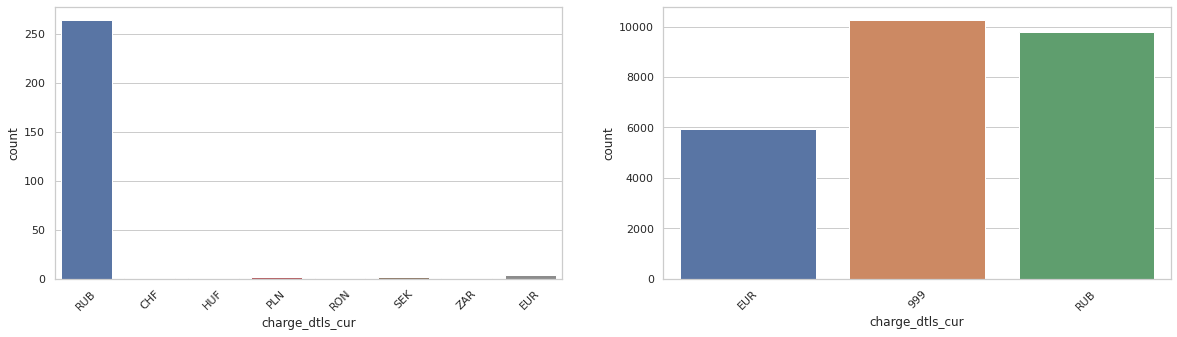

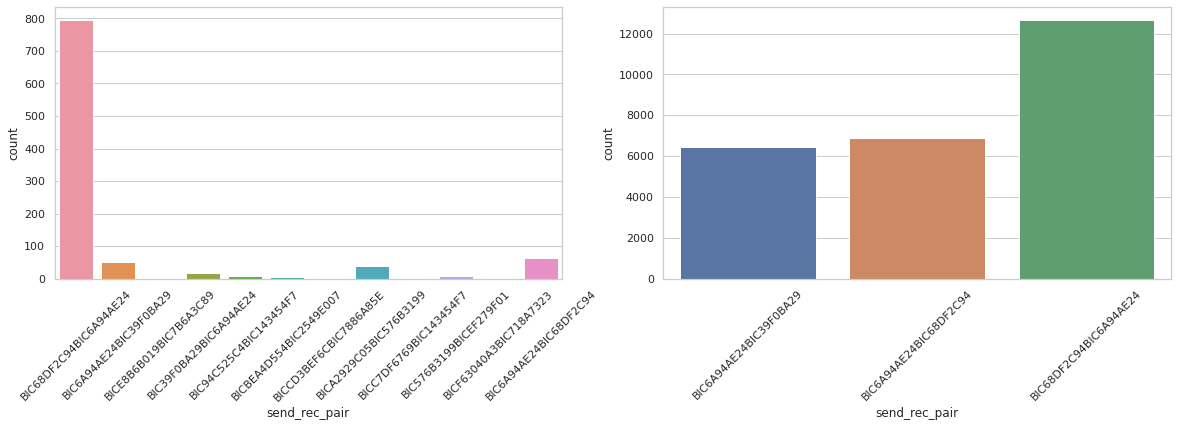

In [41]:
attr_plot(df, samples_fk, discrete = discrete)

#### Univariate numerical distribution

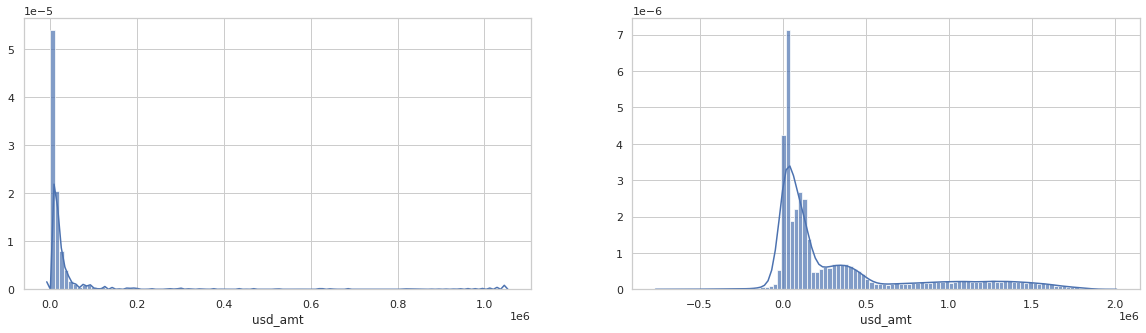

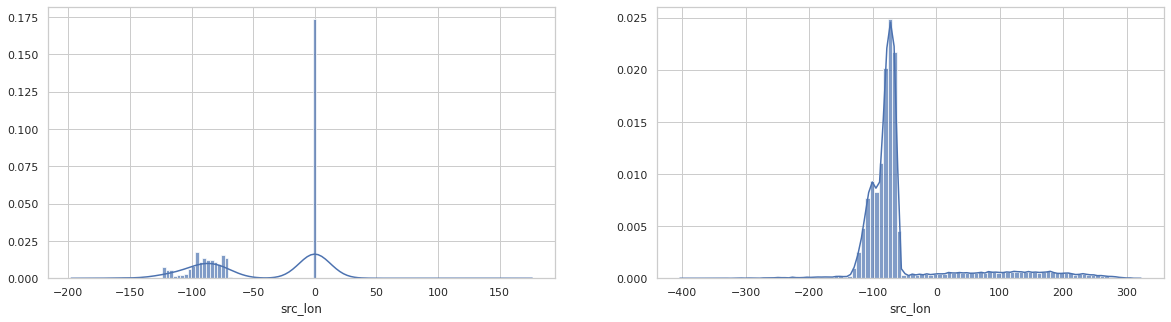

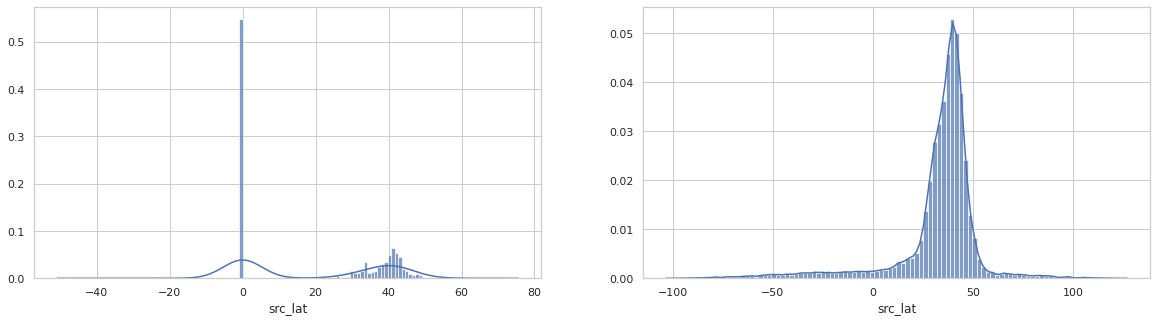

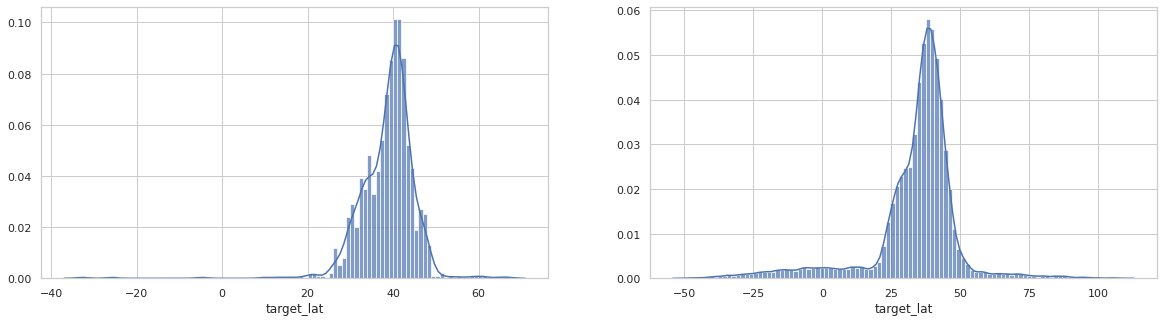

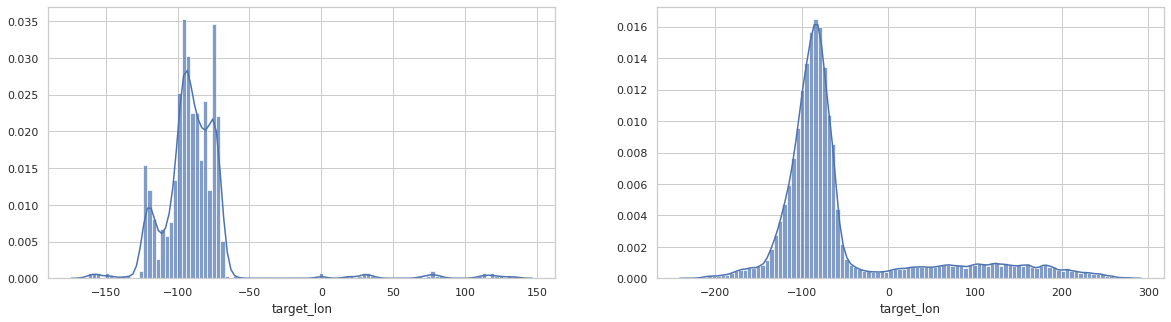

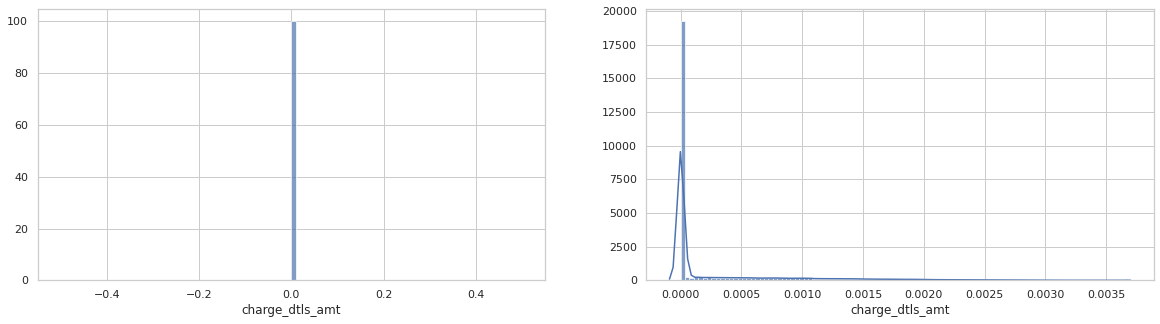

In [42]:
attr_plot(df, samples_fk, numeric = numeric)

In [45]:
datan = DataAnalyser(df, samples_fk)

##### Currency distribution in top 100 transactions

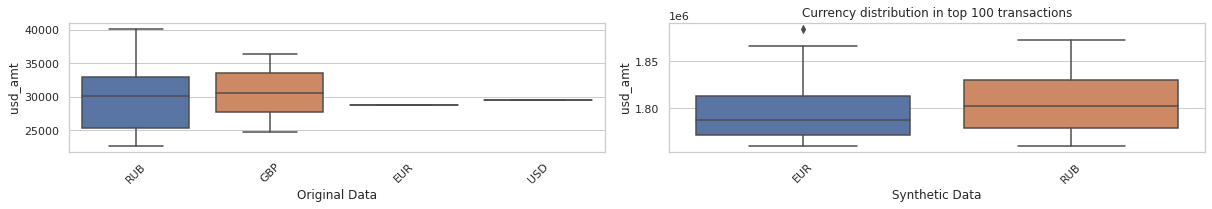

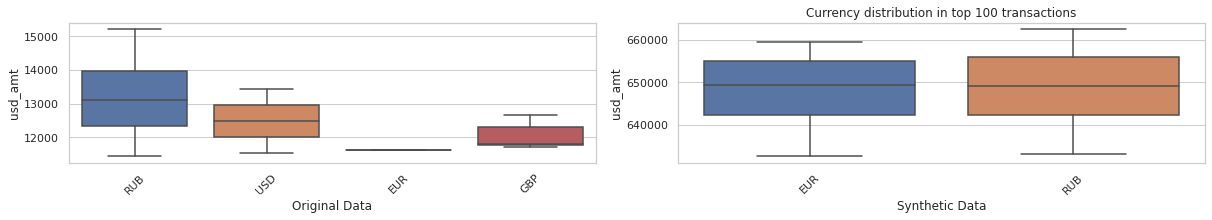

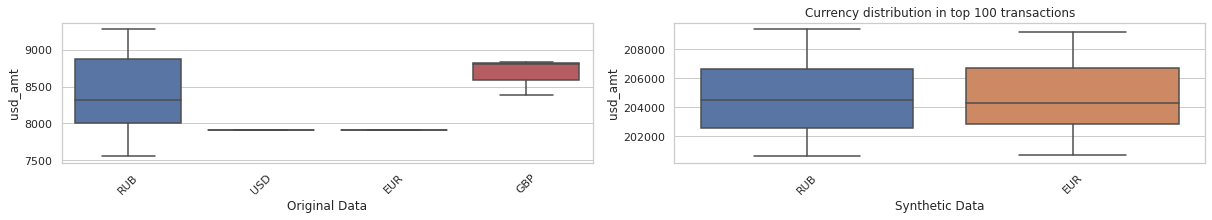

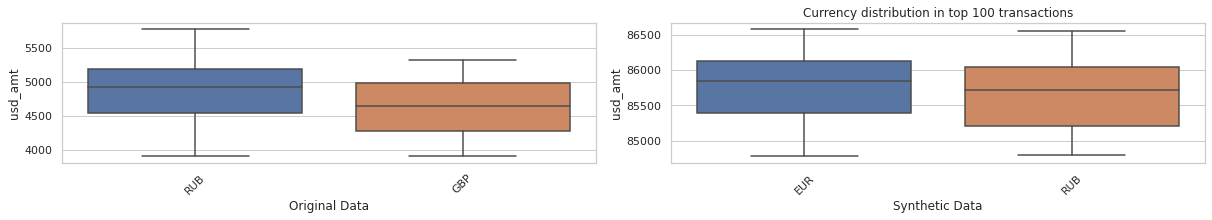

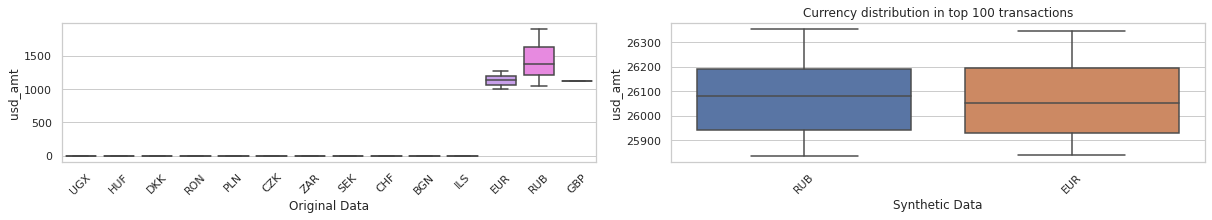

In [46]:
datan.plot_transaction_distribution(bins = 5, value_col = 'usd_amt', top_n = 100)

#### Top transactions hotspots

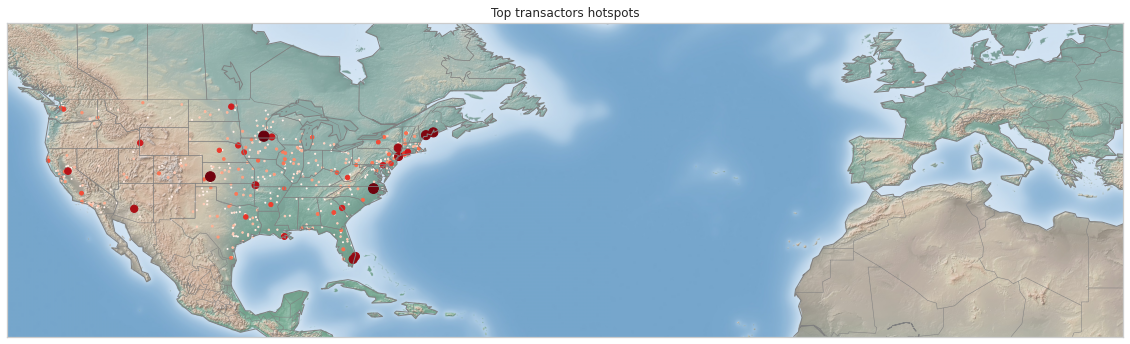

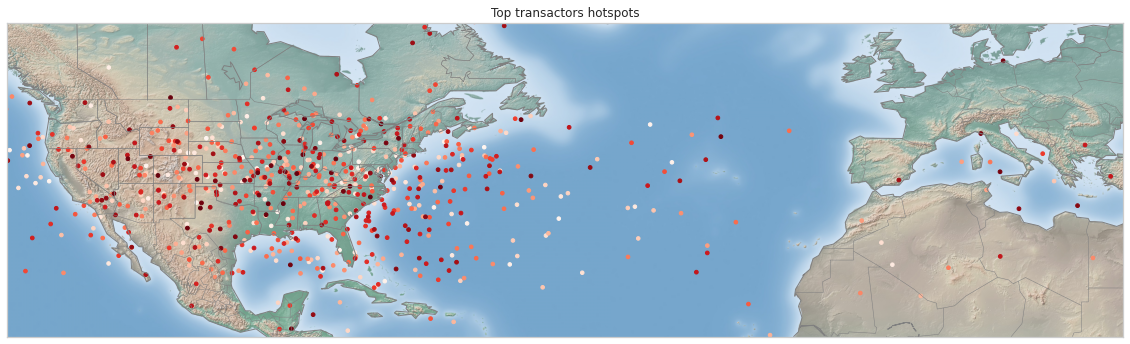

In [47]:
# original data comes first followed by the synthetically generated data
lower_bound_percentile = 0.5 
datan.plot_analysis(lower = lower_bound_percentile, transactor = 'target', value_col = 'usd_amt')

### Generate messages for transaction category Payor -> 'A'

In [18]:
%%time
input_data, sfx = get_input_data()
xfm_datafile = f"data/xfm_datafile{sfx}.csv"
xfm_model = f"models/gan_transformer{sfx}.pkl"
gan_model = f"models/gan_model{sfx}.pkl"
reload_data = True
retrain = True

CPU times: user 1.31 ms, sys: 49 µs, total: 1.36 ms
Wall time: 1.13 ms


In [19]:
%%time
print(datetime.datetime.now())

if reload_data:
    transformer = DataTransformer()
    transformer.fit(input_data, discrete)
    data_ = transformer.transform(input_data)
    pd.DataFrame(data_).to_csv(xfm_datafile, index=False)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    print(f"Loading Datafile: {xfm_datafile} and Transformer: {xfm_model} !!")
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

2021-09-24 08:32:09.273689
CPU times: user 640 ms, sys: 3.83 ms, total: 644 ms
Wall time: 643 ms


In [20]:
%%time
print(datetime.datetime.now())
if retrain:
    synthesizer = DataSynthesizer(epochs = 10, verbose = True, pac = 10, 
                              option = 'cnn', num_filters = [10, 10, 10, 10, 10], 
                              filter_sizes = [2, 3, 4, 5, 6],
                              xfm_indicator = True, transformer = transformer, 
                              xfm_datafile = xfm_datafile)
    synthesizer.fit(data, discrete)
    print("Training completed. Saving the model file !")
    pickle.dump(synthesizer, open(gan_model, 'wb'))
else:
    synthesizer = pickle.load(open(gan_model, 'rb'))

2021-09-24 08:32:09.921123
Initializing synthesizer !!
[[SpanInfo(dim=15, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=4, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')], [SpanInfo(dim=12, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=7, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=5, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=9, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')]]
Tranformer indicator is True
Loading data from data/xfm_datafile_a.csv
Instantiating discriminator with cnn layer as first set of layers !
[2, 3, 4, 5, 6]
DiscriminatorC(
  (conv1d_list): ModuleList(
    (0): Conv1d(40, 10, 

In [21]:
num_samples = 13000

In [22]:
%%time
print(datetime.datetime.now())
samples_a = synthesizer.sample(num_samples)

2021-09-24 08:32:12.495696
CPU times: user 3.17 s, sys: 16.1 ms, total: 3.18 s
Wall time: 1.1 s


In [23]:
%%time
samples_a = reverse_samples_for_analysis(samples_a, sfx = sfx)

Time elasped for 50f_payor_add_ln_2 = 0.0006979679999403743
Time elasped for src_xfrr_type = 0.06982318299992585
Time elasped for 50f_payor_add_lat = 0.003793219000044701
Time elasped for 50f_payor_add_lon = 0.0020156929999757267
Time elasped for 50k_payor_add_lat = 0.0018667829999685637
Time elasped for 50k_payor_add_lon = 0.0018113900000571448
Time elasped for 50k_payor_add_ln_2 = 0.0005543800000396004
Time elasped for 50k_payor_add_ln_2 = 0.07345996200001537
Time elasped for 59f_ben_add_ln_2 = 6.804553672999873
Time elasped for 59f_ben_add_lat = 0.000890644000037355
Time elasped for 59f_ben_add_lon = 0.0007666120000067167
Time elasped for 71A_chg_dtls = 0.0010605709999254032
Time elasped for 71f_chg_dtls_cur = 0.0020634420000078535
Time elasped for 71f_chg_dtls_amt = 0.007275702000015372
CPU times: user 337 ms, sys: 164 ms, total: 502 ms
Wall time: 7.2 s


In [24]:
samples_fk

,33b_cur,usd_amt,src_xfrr_type,src_lon,send_rec_pair,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,...,50f_payor_add_lon,50k_payor_add_lat,50k_payor_add_lon,50k_payor_add_ln_2,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,RUB,4.922599e+05,K,-38.235683,BIC68DF2C94BIC6A94AE24,29.939762,85.497824,-64.800955,OUR,RUB,...,0.000000,29.939762,-38.235683,Invalid geo-coordinates !!,US KILLEN,85.497824,-64.800955,OUR,RUB,0.000000
1,EUR,4.729682e+05,K,-91.014865,BIC68DF2C94BIC6A94AE24,36.758292,42.225514,-68.070625,SHA,RUB,...,0.000000,36.758292,-91.014865,US DYERSVILLE,US EASTPORT,42.225514,-68.070625,SHA,RUB,0.000000
2,EUR,1.033911e+04,F,-97.416853,BIC6A94AE24BIC68DF2C94,28.268408,39.865123,-102.747439,BEN,999,...,-97.416853,0.000000,0.000000,,US DEADWOOD,39.865123,-102.747439,BEN,999,0.000000
3,EUR,3.702190e+04,F,-101.226514,BIC6A94AE24BIC39F0BA29,35.935594,38.469414,-71.969912,SHA,RUB,...,-101.226514,0.000000,0.000000,,US KENNEBUNK,38.469414,-71.969912,SHA,RUB,0.000826
4,EUR,7.581027e+03,K,-85.608732,BIC6A94AE24BIC39F0BA29,41.893148,67.813874,-72.900264,SHA,EUR,...,0.000000,41.893148,-85.608732,US NEW ALBANY,US CHAGRIN FALLS,67.813874,-72.900264,SHA,EUR,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25995,EUR,4.958319e+05,K,-75.149861,BIC6A94AE24BIC68DF2C94,49.632894,41.958430,-75.781152,BEN,999,...,0.000000,49.632894,-75.149861,US SPRING HOPE,US MOUNTAIN TOP,41.958430,-75.781152,BEN,999,0.000000
25996,RUB,1.600274e+05,K,-33.443250,BIC68DF2C94BIC6A94AE24,32.582586,55.823873,-43.031932,SHA,EUR,...,0.000000,32.582586,-33.443250,Invalid geo-coordinates !!,Invalid geo-coordinates !!,55.823873,-43.031932,SHA,EUR,0.000000
25997,RUB,1.396629e+06,F,-114.718493,BIC68DF2C94BIC6A94AE24,42.761646,38.977998,-56.802285,SHA,RUB,...,-114.718493,0.000000,0.000000,,Invalid geo-coordinates !!,38.977998,-56.802285,SHA,RUB,0.000000
25998,RUB,3.693913e+04,F,-123.120118,BIC6A94AE24BIC68DF2C94,16.895716,49.812040,-89.355038,BEN,999,...,-123.120118,0.000000,0.000000,,US POYNETTE,49.812040,-89.355038,BEN,999,0.000000


In [25]:
samples_a

,33b_cur,usd_amt,src_xfrr_type,src_lon,send_rec_pair,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,...,50f_payor_add_lon,50k_payor_add_lat,50k_payor_add_lon,50k_payor_add_ln_2,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,ZAR,2.697502e+04,A,0.002754,BIC68DF2C94BIC6A94AE24,0.000560,33.804487,-80.668965,SHA,999,...,0.0,0.0,0.0,,US SUMMERLAND KEY,33.804487,-80.668965,SHA,999,0.000000
1,USD,7.964209e+04,A,-0.000186,BIC6A94AE24BIC68DF2C94,-0.002915,42.211163,-88.931403,BEN,ZAR,...,0.0,0.0,0.0,,US MAROA,42.211163,-88.931403,BEN,ZAR,0.000000
2,GBP,2.449626e+05,A,0.000103,BIC94C525C4BIC143454F7,0.001221,32.274623,-97.716059,BEN,RON,...,0.0,0.0,0.0,,US MANOR,32.274623,-97.716059,BEN,RON,0.000000
3,DKK,3.524960e+04,A,0.002532,BICE8B6B019BIC7B6A3C89,0.000638,21.663805,-101.754335,BEN,CHF,...,0.0,0.0,0.0,,US WELD,21.663805,-101.754335,BEN,CHF,0.001510
4,BGN,1.136111e+05,A,-0.000024,BIC68DF2C94BIC6A94AE24,-0.001170,-62.929483,-85.015483,BEN,PLN,...,0.0,0.0,0.0,,US MAR LIN,-62.929483,-85.015483,BEN,PLN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,PLN,2.740944e+04,A,-0.001579,BICF63040A3BIC718A7323,-0.001722,26.851087,-72.421267,SHA,PLN,...,0.0,0.0,0.0,,US MILBRIDGE,26.851087,-72.421267,SHA,PLN,0.000000
12996,GBP,1.150145e+06,A,-0.000228,BICBEA4D554BIC2549E007,-0.001564,32.791911,-116.535973,SHA,RON,...,0.0,0.0,0.0,,US SATSOP,32.791911,-116.535973,SHA,RON,0.000000
12997,PLN,7.493167e+04,A,-0.000256,BIC94C525C4BIC143454F7,-0.001812,28.853012,-82.929219,BEN,999,...,0.0,0.0,0.0,,US MARBLE,28.853012,-82.929219,BEN,999,0.000000
12998,USD,2.142806e+05,A,0.001669,BIC576B3199BICEF279F01,0.000528,31.403203,-134.337819,BEN,PLN,...,0.0,0.0,0.0,,Invalid geo-coordinates !!,31.403203,-134.337819,BEN,PLN,0.000758


In [26]:
pd.concat([samples_fk, samples_a])[['33b_cur', 'usd_amt', '50f_payor_add_ln_2', 
                                   '50k_payor_add_ln_2', '59f_ben_add_ln_2',
                                   '71A_chg_dtls', '71f_chg_dtls_cur', '71f_chg_dtls_amt']]

,33b_cur,usd_amt,50f_payor_add_ln_2,50k_payor_add_ln_2,59f_ben_add_ln_2,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,RUB,4.922599e+05,,Invalid geo-coordinates !!,US KILLEN,OUR,RUB,0.000000
1,EUR,4.729682e+05,,US DYERSVILLE,US EASTPORT,SHA,RUB,0.000000
2,EUR,1.033911e+04,US TAPPEN,,US DEADWOOD,BEN,999,0.000000
3,EUR,3.702190e+04,US VENANGO,,US KENNEBUNK,SHA,RUB,0.000826
4,EUR,7.581027e+03,,US NEW ALBANY,US CHAGRIN FALLS,SHA,EUR,0.000000
...,...,...,...,...,...,...,...,...
12995,PLN,2.740944e+04,,,US MILBRIDGE,SHA,PLN,0.000000
12996,GBP,1.150145e+06,,,US SATSOP,SHA,RON,0.000000
12997,PLN,7.493167e+04,,,US MARBLE,BEN,999,0.000000
12998,USD,2.142806e+05,,,Invalid geo-coordinates !!,BEN,PLN,0.000758
